In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

from PIL import Image
import cv2
from glob import glob

from datetime import datetime as dt
import csv, os
from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from scipy import interp

import tensorflow.keras as k
from tensorflow.math import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt

# load tensorboard
%load_ext tensorboard

TensorFlow version: 2.9.0


## 1. load data

In [2]:
# machine = ""
# base = f"{machine}/media/z/0/MVPC10/DATA/v1.1/RAW"
# device = "device_03"
# outpath = f"{base}/{device}"
outpath = f"."
csvfile = f"{outpath}/v1.2_train.csv"

df = pd.read_csv(f'{csvfile}')
df.head

<bound method NDFrame.head of                                                 img_name  cnt
0      /media/z/0/MVPC10/DATA/v1.1/RAW/device_03/2022...    0
1      /media/z/0/MVPC10/DATA/v1.1/RAW/device_03/2022...    0
2      /media/z/0/MVPC10/DATA/v1.1/RAW/device_03/2022...    0
3      /media/z/0/MVPC10/DATA/v1.1/RAW/device_03/2022...    0
4      /media/z/0/MVPC10/DATA/v1.1/RAW/device_03/2022...    0
...                                                  ...  ...
28409  /media/z/0/MVPC10/DATA/v1.1/RAW/device_03/2022...    0
28410  /media/z/0/MVPC10/DATA/v1.1/RAW/device_03/2022...    0
28411  /media/z/0/MVPC10/DATA/v1.1/RAW/device_03/2022...    0
28412  /media/z/0/MVPC10/DATA/v1.1/RAW/device_03/2022...    2
28413  /media/z/0/MVPC10/DATA/v1.1/RAW/device_03/2022...    0

[28414 rows x 2 columns]>

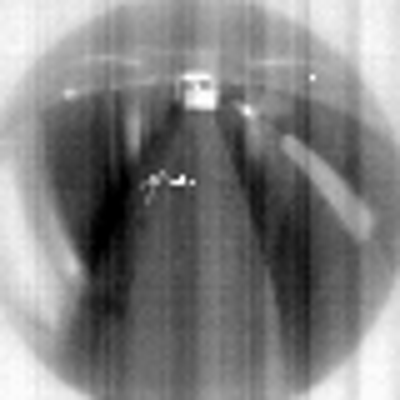

In [6]:
test_img = df.iloc[5,0]
test_img = Image.open(test_img).convert('L')
test_img = test_img.resize((800, 800))
display(test_img)


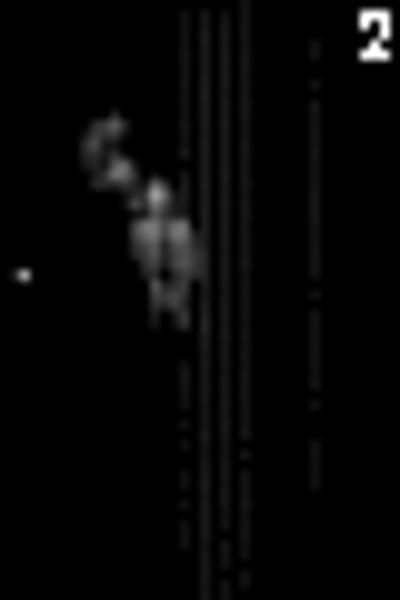

In [5]:
h, w = 80, 80
min, mid, max = 0, 128, 255
error = 239
back_img_list = []


def crop_img(arr):
  new_arr = arr
  lr, tb = w//4, h//4
  new_arr = new_arr[:, w//4:w-w//4]
  new_arr = new_arr[h//4:, :]

  return new_arr


def img1_minus_img2(img1, img2):
  # img3 = np.round_(255-((img1_arr-img2_arr)+255)/2).astype(np.uint8)
  img_dist = img1-img2

  background_img = np.average(img1, axis=0)

  img_dist = crop_img(img_dist)

  img_norm = np.round_(255-(img_dist+255))  # inverse
  img_norm[img_norm < 15] = 0  # low cut

  result = img_norm.astype(np.uint8)  # dtype to uint8

  return result


prev = ""
# prev_cnt = 0
for i in range(len(df)):
  img1_path = df.iloc[i, 0]
  img1_cnt = df.iloc[i, 1]
  img2_path = df.iloc[i+1, 0]
  img2_cnt = df.iloc[i+1, 1]

  # if img2_cnt == 0:
  #   continue

  if img1_cnt == 0:
    prev = img1_path
    # prev_cnt = img1_cnt

  im1 = Image.open(prev)
  im2 = Image.open(img2_path)
  im1_arr = np.array(im1, int)
  im2_arr = np.array(im2, int)

  e1 = im1_arr[im1_arr > 239]
  e2 = im2_arr[im2_arr > 239]
  er1, er2 = len(e1), len(e2)

  if er1 < 512 and er2 < 512:
    result = img1_minus_img2(im1_arr, im2_arr)

    window_name = "out"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    # cv2.putText(result, str(prev_cnt), (0,5), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (255,0,0), 1)
    cv2.putText(result, str(img2_cnt), (35,5), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (255,0,0), 1)
    cv2.imshow(window_name, result)
    ## print(i)
    key = cv2.waitKey()
    if key == 27:
      cv2.destroyAllWindows()
      break
    elif key == ord('s'):
      cv2.imwrite('result.png', result)
    else:
      pass

result = Image.fromarray(result)
result = result.resize((400, 600))
display(result)


In [ ]:
# im = glob(f'/media/z/0/MVPC10/DATA/v1.1/RAW/device_03/**/*.png', recursive=False)
# im = sorted(im)
# # pprint(im)



## MODEL

In [ ]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = Conv2D(32, 3, activation='relu')
    self.flatten = Flatten()
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(10)

  def call(self, x):
    x = self.conv1(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

# Create an instance of the model
model = MyModel()

## optimizer and loss function

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

Select metrics to measure the loss and the accuracy of the model. These metrics accumulate the values over epochs and then print the overall result.

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

## TRAIN : Use `tf.GradientTape` to train the model

In [ ]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

## Test

In [ ]:
@tf.function
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [ ]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

The image classifier is now trained to ~98% accuracy on this dataset. To learn more, read the [TensorFlow tutorials](https://www.tensorflow.org/tutorials).